In [113]:
# Import the required libraries
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import pickle

In [114]:
# Load the data into pandas dataframes. The data has to be manually saved to a folder called 'data'.
# Note: the data is quite large, so this may take a while (~40 seconds) if the data is read as a csv. To speed up further file reading, it is converted to pickle format.
# if (os.path.exists(os.path.join('data', 'training_set_VU_DM.pickle'))
#     & os.path.exists((os.path.join('data', 'test_set_VU_DM.pickle')))):
#     train_df = pd.read_pickle(os.path.join('data', 'training_set_VU_DM.pickle'))
#     test_df = pd.read_pickle(os.path.join('data', 'test_set_VU_DM.pickle'))
# else:
#     train_df = pd.read_csv(os.path.join('data', 'training_set_VU_DM.csv'))
#     test_df = pd.read_csv(os.path.join('data', 'test_set_VU_DM.csv'))
#     train_df.to_pickle(os.path.join('data', 'training_set_VU_DM.pickle'))
#     test_df.to_pickle(os.path.join('data', 'test_set_VU_DM.pickle'))

train_df = pd.read_csv(os.path.join('data', 'dummy_training.csv'))
test_df = pd.read_csv(os.path.join('data', 'dummy_testing.csv'))

In [115]:
print(f"Period of data collection: {pd.to_datetime(train_df['date_time']).min().strftime('%Y/%m/%d')} - {pd.to_datetime(train_df['date_time']).max().strftime('%Y/%m/%d')}")
print(f"Train data contains {train_df.shape[0]:,} rows and {train_df.shape[1]} columns")
print(f"Test data contains {test_df.shape[0]:,} rows and {test_df.shape[1]} columns")
print()
print(f"Train data:")
print(f"Number of unique search IDs: {len(train_df['srch_id'].unique()):,}")
print(f"Number of unique property IDs: {len(train_df['prop_id'].unique()):,}")
print(f"Number of clicks per search: avg. {train_df['click_bool'].sum() / len(train_df['srch_id'].unique()):.2f}, std. {train_df['click_bool'].std():.2f}")
print(f"Number of bookings per search: avg. {train_df['booking_bool'].sum() / len(train_df['srch_id'].unique()):.2f}, std. {train_df['booking_bool'].std():.2f}")
print()
print(f"Test data:")
print(f"Number of unique search IDs: {len(test_df['srch_id'].unique()):,}")
print(f"Number of unique property IDs: {len(test_df['prop_id'].unique()):,}")

Period of data collection: 2012/11/01 - 2013/06/29
Train data contains 4,999 rows and 54 columns
Test data contains 4,999 rows and 50 columns

Train data:
Number of unique search IDs: 207
Number of unique property IDs: 4,602
Number of clicks per search: avg. 1.09, std. 0.21
Number of bookings per search: avg. 0.66, std. 0.16

Test data:
Number of unique search IDs: 194
Number of unique property IDs: 4,551


### Data Columns

| Column Name                 | Data Type | Description                                                                                                                                                                                                       |
|-----------------------------|-----------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| position                    | Integer   | Hotel position on Expedia's search results page. This is only provided for the training data, but not the test data.                                                                                              |
| gross_booking_usd           | Float     | Total value of the transaction. This can differ from the price_usd due to taxes, fees, conventions on multiple day bookings and purchase of a room type other than the one shown in the search                    |
| click_bool                  | Boolean   | 1 if the user clicked on the property, 0 if not.                                                                                              |
| booking_bool                | Boolean   | 1 if the user booked the property, 0 if not.                    |
|                             |           ||
| srch_id                     | Integer   | The ID of the search                                                                                                                                                                                              |
| date_time                   | Date/time | Date and time of the search                                                                                                                                                                                       |
| site_id                     | Integer   | ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ..)                                                                                                                              |
| visitor_location_country_id | Integer   | The ID of the country the customer is located                                                                                                                                                                     |
| visitor_hist_starrating     | Float     | The mean star rating of hotels the customer has previously purchased; null signifies there is no purchase history on the customer                                                                                 |
| visitor_hist_adr_usd        | Float     | The mean price per night (in US$) of the hotels the customer has previously purchased; null signifies there is no purchase history on the customer                                                                |
| prop_country_id             | Integer   | The ID of the country the hotel is located in                                                                                                                                                                     |
| prop_id                     | Integer   | The ID of the hotel                                                                                                                                                                                               |
| prop_starrating             | Integer   | The star rating of the hotel, from 1 to 5, in increments of 1. A 0 indicates the property has no stars, the star rating is not known or cannot be publicized.                                                     |
| prop_review_score           | Float     | The mean customer review score for the hotel on a scale out of 5, rounded to 0.5 increments. A 0 means there have been no reviews, null that the information is not available.                                    |
| prop_brand_bool             | Integer   | +1 if the hotel is part of a major hotel chain; 0 if it is an independent hotel                                                                                                                                   |
| prop_location_score1        | Float     | A (first) score outlining the desirability of a hotel’s location                                                                                                                                                  |
| prop_location_score2        | Float     | A (second) score outlining the desirability of the hotel’s location                                                                                                                                               |
| prop_log_historical_price   | Float     | The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period.                                                                               |
| price_usd                   | Float     | Displayed price of the hotel for the given search. Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay              |
| promotion_flag              | Integer   | +1 if the hotel had a sale price promotion specifically displayed                                                                                                                                                 |
| srch_destination_id         | Integer   | ID of the destination where the hotel search was performed                                                                                                                                                        |
| srch_length_of_stay         | Integer   | Number of nights stay that was searched                                                                                                                                                                           |
| srch_booking_window         | Integer   | Number of days in the future the hotel stay started from the search date                                                                                                                                          |
| srch_adults_count           | Integer   | The number of adults specified in the hotel room                                                                                                                                                                  |
| srch_children_count         | Integer   | The number of (extra occupancy) children specified in the hotel room                                                                                                                                              |
| srch_room_count             | Integer   | Number of hotel rooms specified in the search                                                                                                                                                                     |
| srch_saturday_night_bool    | Boolean   | +1 if the stay includes a Saturday night, starts from Thursday with a length of stay is less than or equal to 4 nights (i.e. weekend); otherwise 0                                                                |
| srch_query_affinity_score   | Float     | The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)                      |
| orig_destination_distance   | Float     | Physical distance between the hotel and the customer at the time of search. A null means the distance could not be calculated.                                                                                    |
| random_bool                 | Boolean   | +1 when the displayed sort was random, 0 when the normal sort order was displayed                                                                                                                                 |
| comp*x*_rate                | Integer   | '*x*' denotes the competitor number. +1 if Expedia has a lower price than competitor 1 for the hotel; 0 if the same; -1 if Expedia’s price is higher than competitor 1; null signifies there is no competitive data |
| comp*x*_inv                 | Integer   | '*x*' denotes the competitor number. +1 if competitor 1 does not have availability in the hotel; 0 if both Expedia and competitor 1 have availability; null signifies there is no competitive data                  |
| comp*x*_rate_percent_diff   | Float     | '*x*' denotes the competitor number. The absolute percentage difference (if one exists) between Expedia and competitor 1’s price (Expedia’s price the denominator); null signifies there is no competitive data      |


# Data Transformation

In [116]:
def create_features(df):
    """
    Create the following new features: has_starrating, has_review_score, traveling_abroad, srch_prop_country_match, month, and day_of_week
    """
    # has_starrating: boolean whether prop_starrating is 0 or null
    df["has_starrating"] = df["prop_starrating"].isnull()
    df["has_starrating"] = df["has_starrating"].astype(int)
    df.loc[df["prop_starrating"] == 0, "has_starrating"] = 1

    # has_review_score: boolean whether prop_review_score is 0 or null
    df["has_review_score"] = df["prop_review_score"].isnull()
    df["has_review_score"] = df["has_review_score"].astype(int)
    df.loc[df["prop_review_score"] == 0, "has_review_score"] = 1

    # traveling_abroad: boolean whether visitor_location_country_id != prop_country_id
    df["traveling_abroad"] = df["visitor_location_country_id"] != df["prop_country_id"]
    df["traveling_abroad"] = df["traveling_abroad"].astype(int)

    # srch_prop_country_match: boolean whether srch_destination_id == prop_country_id
    df["srch_prop_country_match"] = df["srch_destination_id"] == df["prop_country_id"]
    df["srch_prop_country_match"] = df["srch_prop_country_match"].astype(int)

    # month: month of the search, one-hot encoded
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["month"] = df["date_time"].dt.month
    df["month"] = df["month"].map({1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun", 7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"})
    df = pd.get_dummies(df, columns=["month"], dtype=int)
    for col in ["month_jan", "month_feb", "month_mar", "month_apr", "month_may", "month_jun", "month_jul", "month_aug", "month_sep", "month_oct", "month_nov", "month_dec"]:
        if col not in df.columns:
            df[col] = 0

    # day_of_week: day of the week of the search
    df["day_of_week"] = df["date_time"].dt.dayofweek
    df["day_of_week"] = df["day_of_week"].map({0: "mon", 1: "tue", 2: "wed", 3: "thu", 4: "fri", 5: "sat", 6: "sun"})
    df = pd.get_dummies(df, columns=["day_of_week"], dtype=int)
    for col in ["day_of_week_mon", "day_of_week_tue", "day_of_week_wed", "day_of_week_thu", "day_of_week_fri", "day_of_week_sat", "day_of_week_sun"]:
        if col not in df.columns:
            df[col] = 0

    return df

In [117]:
def drop_nan_columns(df):
    """
    Train data shows that "visitor_hist_starrating", "visitor_hist_adr_usd", "srch_query_affinity_score", and "compx_rate_percent_diff" have >90% NaN values. These values cannot be imputed accurately, so we drop these columns.
    """
    cols = ["visitor_hist_starrating", "visitor_hist_adr_usd", "srch_query_affinity_score"] + [f"comp{i}_rate_percent_diff" for i in range(1, 9)]
    df.drop(columns=cols, inplace=True)
    return df

In [118]:
def impute_missing_values(df):
    """
    Impute missing values for the following columns: "prop_starrating", "prop_review_score", "compx_rate", and "compx_inv".

    For "prop_starrating" and "prop_review_score", we replace 0 values with NaN and then impute the NaN values with the mean per srch_id. Remaining NaN values are then filled with 0.
    For "compx_rate" and "compx_inv", we assume that missing data means that Expedia has the same price and equal availability as its competitors. We therefore impute the NaN values with 0.
    """
    # Replace 0 values with NaN
    df["prop_starrating"] = df["prop_starrating"].replace(0, np.nan)
    df["prop_review_score"] = df["prop_review_score"].replace(0, np.nan)
    # Impute NaN values with mean per srch_id
    df["prop_starrating"] = df.groupby("srch_id")["prop_starrating"].transform(lambda x: x.fillna(x.mean()))
    df["prop_review_score"] = df.groupby("srch_id")["prop_review_score"].transform(lambda x: x.fillna(x.mean()))
    # Fill remaining NaN values with 0
    df["prop_starrating"] = df["prop_starrating"].fillna(0)
    df["prop_review_score"] = df["prop_review_score"].fillna(0)

    # Impute NaN values with 0
    for i in range(1, 9):
        df[f"comp{i}_rate"] = df[f"comp{i}_rate"].fillna(0)
        df[f"comp{i}_inv"] = df[f"comp{i}_inv"].fillna(0)

    return df

In [119]:
def compute_aggregated_values(df):
    """
    Compute the mean, median and standard deviation for the following columns:
    "visitor_hist_starrating", "visitor_hist_adr_usd", "prop_starrating", "prop_review_score", "prop_location_score1", "prop_log_historical_price", "price_usd"
    """
    numerical_cols = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_log_historical_price", "price_usd"]
    # srch_length_of_stay, srch_booking_window, srch_adults_count, srch_children_count, and srch_room_count are also numerical variables, but it has no use aggregating these values over prop_id.

    agg_df = df.groupby("prop_id").agg({col: ["mean", "std", "median"] for col in numerical_cols})
    agg_df.columns = ["_".join(col) for col in agg_df.columns]
    agg_df.fillna(0, inplace=True)  # Fill standard deviation NaN values with 0
    for col in agg_df.columns:
        df[col] = df["prop_id"].map(agg_df[col])
    return df

In [120]:
def compute_relative_values(df):
    """
    Subtract the mean per srch_id from the following columns:
    "prop_starrating", "prop_review_score", "prop_location_score1", "prop_log_historical_price", "price_usd"

    This is done so that the model can learn the relative values of these columns per srch_id.
    """
    cols = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_log_historical_price", "price_usd"]
    grouper = df.groupby('srch_id')
    for col in cols:
        df[col] = df[col] - grouper[col].transform('mean')
    return df

In [121]:
def drop_columns(df):
    """
    Train data shows that for "orig_destination_distance" over 75% of the data with a calculated value lower than 0.95 of the largest distance was lower than 130, meaning that the distance per srch_id is roughly the same. We assume therefore that this is not a deciding factor for a customer in their booking process and drop this column.

    Features were created from "date_time" and the column will not be used anymore, so we drop this column as well.

    Columns containing IDs ("site_id", "visitor_location_country_id", "prop_country_id", "prop_id", and "srch_destination_id") are not used in the model, so we drop these columns as well. "srch_id" and "prop_id" will remain in the columns for now for later use.

    If the supplied dataframe is the training dataframe, drop the unused target columns as well.

    # TODO:
    I don't really know what to do with "prop_location_score2" yet, so I'll drop it for now.
    """
    df.drop(columns=["orig_destination_distance"], inplace=True)
    df.drop(columns=["date_time"], inplace=True)
    df.drop(columns=["site_id", "visitor_location_country_id", "prop_country_id", "srch_destination_id"], inplace=True)
    df.drop(columns=["prop_location_score2"], inplace=True)
    for col in ["position", "gross_bookings_usd"]:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    return df

In [122]:
def process_data(train_df: pd.DataFrame, test_df: pd.DataFrame, target_value: str = "booking_bool"):
    """
    Process the dataframes for training and testing the model.
    :param train_df: The training dataframe
    :param test_df: The test dataframe
    :param target_value: The target value to use for training the model. Either "booking_bool" or "both".
    :return: The processed dataframes
    """
    # Create features
    train_df = create_features(train_df)
    test_df = create_features(test_df)

    # Drop columns with NaN values
    train_df = drop_nan_columns(train_df)
    test_df = drop_nan_columns(test_df)

    # Impute missing values
    train_df = impute_missing_values(train_df)
    test_df = impute_missing_values(test_df)

    # Compute aggregated values
    train_df = compute_aggregated_values(train_df)
    test_df = compute_aggregated_values(test_df)

    # Compute relative values
    train_df = compute_relative_values(train_df)
    test_df = compute_relative_values(test_df)

    # Drop columns
    train_df = drop_columns(train_df)
    test_df = drop_columns(test_df)

    # Split train data into features and target
    if target_value == "booking_bool":
        train_df["target"] = train_df["booking_bool"]
    elif target_value == "both":
        train_df["target"] = 5*train_df["booking_bool"] + train_df["click_bool"]
    else:
        raise ValueError("target_value must be either 'booking_bool' or 'both'")

    train_df.drop(columns=["booking_bool", "click_bool"], inplace=True)

    return train_df, test_df

### DataLoaders

In [123]:
class TrainDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        row = self.data[idx]
        return row["srch_id"], row["prop_id"], torch.tensor(row["sequence"].astype(np.float64)), row["target"]

    def __len__(self):
        return len(self.data)

In [124]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        row = self.data[idx]
        return row["srch_id"], row["prop_id"], torch.tensor(row["sequence"].astype(np.float64))

    def __len__(self):
        return len(self.data)

In [125]:
def generate_sequences(df: pd.DataFrame, kind: str = "train") -> dict:
    """
    Generate sequences from the dataframe.
    :param df: The dataframe to take the sequences from.
    :param kind: The kind of dataframe. Either "train" or "test".
    :return: Dictionary containing the sequences and targets for the training data.
    """
    sequences = []
    if kind == "train":
        idx_dict = df.to_dict("index")
        df = df.drop(columns=["prop_id", "srch_id", "target"])
        for i, idx in enumerate(tqdm(idx_dict, desc="Train DataLoader")):
            sequences.append({"srch_id": idx_dict[idx]["srch_id"], "prop_id": idx_dict[idx]["prop_id"], "sequence": df.iloc[i].values, "target": idx_dict[idx]["target"]})
    elif kind == "test":
        idx_dict = df.to_dict("index")
        df = df.drop(columns=["prop_id", "srch_id"])
        for i, idx in enumerate(tqdm(idx_dict, desc="Train DataLoader")):
            sequences.append({"srch_id": idx_dict[idx]["srch_id"], "prop_id": idx_dict[idx]["prop_id"], "sequence": df.iloc[i].values})
    else:
        raise ValueError("kind must be either 'train' or 'test'")
    return sequences

In [126]:
def create_dataloaders(train_df: pd.DataFrame, test_df: pd.DataFrame, target_value: str = "booking_bool", batch_size: int=1, train_validation_split: float=0.8, shuffle: bool=True, force_data_processing: bool = False) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create dataloaders for the training, validation and test set.
    :param train_df: The train dataframe.
    :param test_df: The test dataframe.
    :param target_value: The target value to use for training the model. Either "booking_bool" or "both".
    :param batch_size: How many samples per batch to load.
    :param train_validation_split: The percentage of the dataset to use for training.
    :param shuffle: Set to True to have the data reshuffled at every epoch.
    :param force_data_processing: Set to True to force the data to be processed again.
    :return: Tuple containing the training, validation and test dataloaders.
    """
    # The files 'final_train_set_booking_bool.pickle' and 'final_test_set_booking_bool.pickle' can be deleted, as they are not used anymore.
    if os.path.exists(os.path.join('data', f'train_sequences_{target_value}.pickle')) \
            & os.path.exists(os.path.join('data', f'test_sequences_{target_value}.pickle')) \
            & (not force_data_processing):
        with open(os.path.join('data', f'train_sequences_{target_value}.pickle'), 'rb') as f:
            train_sequences = pickle.load(f)
        with open(os.path.join('data', f'test_sequences_{target_value}.pickle'), 'rb') as f:
            test_sequences = pickle.load(f)
    else:
        train_df, test_df = process_data(train_df, test_df, target_value=target_value)
        train_sequences = generate_sequences(train_df, kind="train")
        with open(os.path.join('data', f'train_sequences_{target_value}.pickle'), 'wb') as f:
            pickle.dump(train_sequences, f)
        test_sequences = generate_sequences(test_df, kind="test")
        with open(os.path.join('data', f'test_sequences_{target_value}.pickle'), 'wb') as f:
            pickle.dump(test_sequences, f)

    train_dataset = TrainDataset(train_sequences)
    train_size = int(train_validation_split * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    test_dataset = TestDataset(test_sequences)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader, val_dataloader, test_dataloader

**Models**

In [127]:
# Relevant imports
import torch
import torch.nn as nn

In [128]:
# Load all data
train_loader, dev_loader, test_loader = create_dataloaders(train_df, 
                                                           test_df,
                                                           target_value="booking_bool",
                                                           batch_size=32,
                                                           train_validation_split=0.8,
                                                           shuffle=True,
                                                           force_data_processing=True)

for _, _, features, targets in train_loader:
    print(f"Training features shape: {features.size()}")
    print(f"Training targets shape: {targets.size()}")
    break

for _, _, features in test_loader:
    print(f"Testing features shape: {features.size()}")
    print(f"Testing targets shape: {targets.size()}")
    break

Train DataLoader: 100%|██████████| 4999/4999 [00:00<00:00, 7625.11it/s]


Training features shape: torch.Size([32, 68])
Training targets shape: torch.Size([32])
Testing features shape: torch.Size([32, 68])
Testing targets shape: torch.Size([32])


In [129]:
# Calculate NDCG@k score from file

def NDCG_from_file(fn, data, k):
    """
    Function to calculate the NDCG@k score from a txt file in the format specified in the assignment (two 
    columns, the left one containing the search IDs and the right one containing the PropertyIDs, sorted by
    relevance)
    """
    query_to_properties = {}
    
    # Fill the query-to-properties dictionary
    with open(fn) as f:
        lines = f.readlines()[1:] # Remove the header
        for line in lines:
            query_id, prop_id = line.split(",")
            query_id, prop_id = int(query_id), int(prop_id)
            if query_id not in query_to_properties.keys():
                query_to_properties[query_id] = [prop_id]
            else:
                query_to_properties[query_id].append(prop_id)

    NDCG_score = 0
    for query_id, prop_ids in query_to_properties.items():
        
        # TODO: change this to match the correct query
        data_query = data[query_id]

        # Only select the first k properties
        prop_selection = prop_ids[:k]

        # TODO: Change "scores" to match the name of the column which keeps the scores (5 for booking, 1 for clicking)
        true_scores = data.loc(data_query["prop_id"] == prop_selection, "scores")
    
        # Calculate DCG@k (Discounted Cumulative Gain at k)
        dcg = np.sum(true_scores / np.log2(np.arange(2, k+2)))
        
        # Sort the true scores in descending order
        true_sorted_indices = np.argsort(data_query["scores"])[::-1]
        true_sorted_scores = np.array(data_query["scores"])[true_sorted_indices]
        
        # Calculate ideal DCG@k
        ideal_dcg = np.sum(true_sorted_scores[:k] / np.log2(np.arange(2, k+2)))
        
        # Calculate NDCG@k
        NDCG_score += dcg / ideal_dcg if ideal_dcg > 0 else 0.0

    return NDCG_score

In [130]:
# Simple Neural model
class RecommenderNet(nn.Module):
    """
    Neural prediction model for predicting the probability that a user will buy 
    a room at a certain hotel.
    """
    def __init__(self, num_features, hidden_size=64, dropout_bool=False):
        super().__init__()
        self.embedding = nn.Linear(num_features, hidden_size)
        self.layer_norm = nn.LayerNorm(num_features)
        self.dropout = nn.Dropout(0.5)
        self.dropout_bool = dropout_bool

        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc3 = nn.Linear(hidden_size//4, 1)

    def forward(self, features):
        x = self.layer_norm(features.float())
        x = self.embedding(x)
        x = nn.ReLU()(x)
        if self.dropout_bool:
            x = self.dropout(x)
        
        x = self.fc1(x)
        x = nn.ReLU()(x)
        if self.dropout_bool:
            x = self.dropout(x)
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        if self.dropout_bool:
            x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

_Training and testing code_

In [131]:
import torch.optim as optim

def train(model, criterion, num_epochs, learning_rate, train_loader, val_loader, device):
    train_loss = []
    val_loss = []    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(num_epochs):
        print(f"Now training epoch {epoch}")

        # Training loop
        running_train_loss = 0
        for _, _, features, targets in tqdm(train_loader):
            optimizer.zero_grad()
            
            outputs = model(features.squeeze().to(device))
            loss = criterion(outputs.to(device).squeeze().float(), targets.to(device).squeeze().float())
            loss.backward()

            running_train_loss += loss.item()
            
            optimizer.step()

        train_loss.append(running_train_loss)

        # Validation loop
        running_val_loss = 0
        for _, _, features, targets in val_loader:
            with torch.no_grad():
                outputs = model(features.to(device))
                loss = criterion(outputs.to(device).squeeze().float(), targets.to(device).squeeze().float())
                running_val_loss += loss.item()

        val_loss.append(running_val_loss)

    return train_loss, val_loss


def test_and_write(fn, model, loader):

    srch_to_properties = {}
    srch_to_probabilities = {}

    for elem in tqdm(loader):
        # Check if there are four elements in the dataloader (a feature vector and a label).
        # If so, we have the validation set and need to extract the features accordingly
        if len(elem) == 4:
            search_ids, prop_ids, features, _ = elem
        else:
            search_ids, prop_ids, features = elem 

        for i, srch_id in enumerate(search_ids):
            # Check if the current search id is not yet in the dictionaries
            if srch_id.item() not in srch_to_properties.keys():
                srch_to_properties[srch_id.item()] = []
                srch_to_probabilities[srch_id.item()] = []

            srch_to_properties[srch_id.item()].append(prop_ids[i])

        model.eval()
        with torch.no_grad():
            # Don't take into account the search ID (first feature)
            outputs = model(features.squeeze())
            probabilities = torch.sigmoid(outputs.squeeze())

        for i, srch_id in enumerate(search_ids):
            srch_to_probabilities[srch_id.item()].append(probabilities[i])

        #     sorted_indices = probabilities.argsort(descending=True)

        # property_ids = prop_ids.squeeze()[sorted_indices]
            
    with open(fn, "w") as f:
        f.write("srch_id,prop_id\n")
        for srch_id, srch_probs in srch_to_probabilities.items():
            sorted_indices = torch.tensor(srch_probs).argsort(descending=True)
            property_ids_sorted = np.array(srch_to_properties[srch_id])[np.array(sorted_indices)]

            for s_id, p_id in zip([srch_id for _ in range(len(property_ids_sorted))],property_ids_sorted):
                f.write(f"{s_id},{p_id}\n")

In [133]:
# Train simple NN model
num_epochs = 1
hidden_dim = 128
num_features = 68
learning_rate =  3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

simple_nn_model = RecommenderNet(num_features, hidden_size=hidden_dim, dropout_bool=False)
simple_nn_criterion = nn.BCEWithLogitsLoss()

print(f"Training on device: {device}")
print(f"Now training simple MLP model (without dropout)")
nn_train_loss, nn_val_loss = train(simple_nn_model, simple_nn_criterion, num_epochs, learning_rate, train_loader, dev_loader, device)

Training on device: cpu
Now training simple MLP model (without dropout)
Now training epoch 0


100%|██████████| 125/125 [00:00<00:00, 355.80it/s]


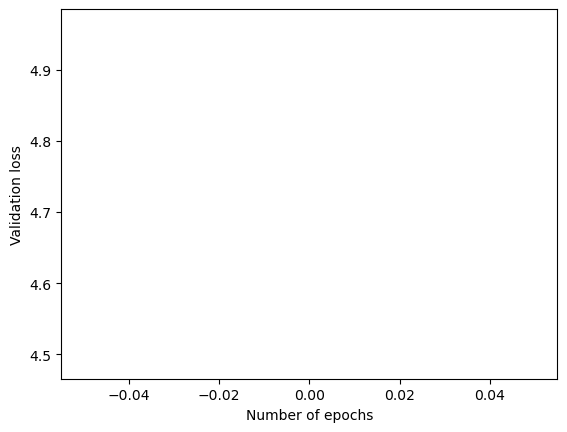

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), nn_train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.savefig("simple_nn_training_loss.png")
plt.clf()

plt.plot(range(num_epochs), nn_val_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.savefig("simple_nn_validation_loss.png")

In [134]:
# Test and save results of simple NN model
if not os.path.isdir("test_output"):
    os.makedirs("test_output")

# For validation set
test_and_write("test_output/dummy_val.csv", simple_nn_model, dev_loader)
# And for testing set
test_and_write("test_output/dummy_test.csv", simple_nn_model, test_loader)

100%|██████████| 157/157 [00:00<00:00, 746.94it/s]


In [ ]:
# simple_nn_model_dropout = RecommenderNet(num_features, hidden_size=hidden_dim, dropout_bool=True)
# simple_nn_criterion_dropout = nn.BCEWithLogitsLoss()

# print(f"Now training simple MLP model (with dropout)")
# nn_train_loss_dropout, nn_val_loss_dropout = train(simple_nn_model_dropout, simple_nn_criterion_dropout, num_epochs, learning_rate, train_loader, dev_loader, device)

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(range(num_epochs), nn_train_loss_dropout)
# plt.xlabel("Number of epochs")
# plt.ylabel("Training loss")
# plt.savefig("simple_nn_training_loss_dropout.png")
# plt.clf()

# plt.plot(range(num_epochs), nn_val_loss_dropout)
# plt.xlabel("Number of epochs")
# plt.ylabel("Validation loss")
# plt.savefig("simple_nn_validation_loss_dropout.png")

In [ ]:
# # Also save results for the dropout model
# # For validation set
# test_and_write("test_output/simple_nn_dropout_val.csv", simple_nn_model_dropout, dev_loader)
# # And for testing set
# test_and_write("test_output/simple_nn_dropout_test.csv", simple_nn_model_dropout, test_loader)

In [ ]:
# Calculate NDCG score for validation set
# nn_score = NDCG_from_file("simple_nn_val.txt", train_df, 5)
# print(f"NDGC score for the simple MLP (on validation set): {nn_score}")